## Emergency Department (ED) System Case Study (Operational Research)
### ***Modelling Hospital ED System Operations with SimPy***
**Objectives:** To model performance of ED System set-up to understand system efficieny and patient experience

***Entities:** Patients, **Resources:** Doctors, Nurses & ED Beds*
- <Insert process flow, Inputs & Simulation outputs to measure performance>

**Use of Probability Distributions:**
- Normal Distribution (mean & standard deviation) to model wait times
    - eg. use mean consult time of 20mins with SD of 5mins (meaning on average, each data point for consult time differs from mean by 5 mins)
- Exponential Distribution to model patient inter-arrival times
    - The probability distribution of the time between events in a Poisson point process, i.e., a process in which events occur continuously and independently at a constant average rate λ (λ > 0). 
    - Simplified best distribution to model inter-arrival times between patients (when supplemented with average interval times from hospital records)

In [1]:
# Import dependencies
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt


#### Breakdown of wait times for each process 
*Needs to be backed by domain from ED*
- **Consulting a doctor:** Normal Distribution with mean of 20mins & SD of 5mins, minimum 5mins.
- **Waiting for medications:** Normal Distribution with mean of 15mins & SD of 3mins, minimum 5mins.
- **Lab-test (fast):** Normal Distribution with mean of 25mins & SD of 5mins, minimum 10mins.
- **Lab-test (main ED):** Normal Distribution with mean of 40mins & SD of 10mins, minimum 15mins.
- **Review after lab-test:** Normal Distribution with mean of 10mins & SD of 3mins, minimum 3mins.
- **Admission for further treatment:** Normal Distribution with mean of 30mins & SD of 5mins, minimum 5mins.

In [2]:
# Create Hospital class to store resources and events/processes
class Hospital(object): 
    def __init__(self, env, num_fast_doctors, num_fast_nurses, num_ed_doctors, num_ed_nurses, num_beds): 
        self.env = env
        self.fast_doctor = simpy.Resource(env, num_fast_doctors)
        self.fast_nurse = simpy.Resource(env, num_fast_nurses)
        self.ed_doctor = simpy.Resource(env, num_ed_doctors)
        self.ed_nurse = simpy.Resource(env, num_ed_nurses)
        self.beds = simpy.Resource(env, num_beds)

    # consulting a doctor
    def consult(self, patient): 
        service_time = np.random.normal(20, 5)
        service_time = max(5, service_time) # no negative durations
        yield self.env.timeout(service_time)
    
    # wait for medications
    def medication(self, patient): 
        service_time = np.random.normal(15, 3)
        service_time = max(5, service_time)
        yield self.env.timeout(service_time)

    # wait for nurse to perform lab-test (fast-track) - Involves nurse
    def fast_lab(self, patient): 
        service_time = np.random.normal(6, 3)
        service_time = max(1, service_time)
        yield self.env.timeout(service_time)

    # wait for lab-test (fast-track) - No resource used.
    def fast_lab_wait(self, patient): 
        service_time = np.random.normal(25, 5)
        service_time = max(10, service_time)
        yield self.env.timeout(service_time)
    
     # wait for lab-test (main ED) - Involves nurse
    def ed_lab(self, patient): 
        service_time = np.random.normal(10, 4)
        service_time = max(3, service_time)
        yield self.env.timeout(service_time)
    
    # wait for lab-test (main ED) - No resource used.
    def ed_lab_wait(self, patient): 
        service_time = np.random.normal(40, 10)
        service_time = max(15, service_time)
        yield self.env.timeout(service_time)

    # review - after taking lab-test
    def review(self, patient):
        service_time = np.random.normal(10, 3)
        service_time = max(3, service_time)
        yield self.env.timeout(service_time)

    # re-admission to other dept for further treatment
    def admit(self, patient): 
        service_time = np.random.normal(30, 5)
        service_time = max(5, service_time)
        yield self.env.timeout(service_time)

In [3]:
## Store variables - Queue tracking
queue_fast, queue_ed = [], []

## Store wait times & timeline (for plots)
wait_times, timeline = [], []

## Utilizations
util_fast_doc = []
util_fast_nurse = []
util_ed_doc = []
util_ed_nurse = []
util_beds = []

##### [Inserts Process flow]

##### Breakdown of probabilities for event splits
- **Fast-track vs Main ED Patient:** 30% probability that patient is admitted to fast-track vice-versa
- **Lab-test for fast-track patients:** 30% probability that fast-track patient requires lab-test
- **Lab-test for main ED patients:** 70% probability that main ED patient requires lab-test
- **Admissions for main ED patients:** 50% probability that main ED patient will be admitted for further treatment.

In [4]:
# Define patient process - Refer to process flow above.
def patient(env, patient, hospital):
    arrival_time = env.now
    is_fast_track = random.random() < 0.3  # 30% go to fast-track

    if is_fast_track:
        # Step 1: consult doctor
        with hospital.fast_doctor.request() as request:
            yield request
            yield env.process(hospital.consult(patient))

        # Step 2: lab test - 30% chance
        if random.random() < 0.3:
            with hospital.fast_nurse.request() as request:
                yield request
                yield env.process(hospital.fast_lab(patient))
            # patient waits alone.
            yield env.process(hospital.fast_lab_wait(patient))
            # doctor's review
            with hospital.fast_doctor.request() as request:
                yield request
                yield env.process(hospital.review(patient))

        # Step 3: medication
        with hospital.fast_nurse.request() as request:
            yield request
            yield env.process(hospital.medication(patient))

    else:
        # Step 1: consult ED doctor
        with hospital.ed_doctor.request() as request:
            yield request
            yield env.process(hospital.consult(patient))

        # Step 2: lab test - 70% chance
        if random.random() < 0.7:
            with hospital.ed_nurse.request() as request:
                yield request
                yield env.process(hospital.ed_lab(patient))
            # patient waits alone. 
            yield env.process(hospital.ed_lab_wait(patient))
            # doctor's review
            with hospital.ed_doctor.request() as request:
                yield request
                yield env.process(hospital.review(patient))

        # Step 3: admission OR medication
        if random.random() < 0.5:
            with hospital.beds.request() as bed_req:
                yield bed_req
                yield env.process(hospital.admit(patient))
        else:
            with hospital.ed_nurse.request() as nurse_req:
                yield nurse_req
                yield env.process(hospital.medication(patient))

    wait_times.append(env.now - arrival_time)

##### Monitor function to track metrics (every 5 minutes): 
1. Queue lengths for fast-track and Main ED patients
2. Utilisation of resources - Doctors, Nurses (for both Fast-Track and Main ED processes) + Beds (Main ED process)

In [5]:
# Monitor function 
def monitor(env, hospital, timeline,
            queue_fast, queue_ed,
            util_fast_doc, util_fast_nurse,
            util_ed_doc, util_ed_nurse,
            util_beds,
            interval=5):
    while True:
        # Time snapshot
        timeline.append(env.now)

        # Queue lengths
        q_fast = len(hospital.fast_doctor.queue) + len(hospital.fast_nurse.queue)
        q_ed = len(hospital.ed_doctor.queue) + len(hospital.ed_nurse.queue)
        queue_fast.append(q_fast)
        queue_ed.append(q_ed)

        # Utilizations - .count = how many patients are currently served..capacity = total number.
        util_fast_doc.append(hospital.fast_doctor.count / hospital.fast_doctor.capacity)
        util_fast_nurse.append(hospital.fast_nurse.count / hospital.fast_nurse.capacity)
        util_ed_doc.append(hospital.ed_doctor.count / hospital.ed_doctor.capacity)
        util_ed_nurse.append(hospital.ed_nurse.count / hospital.ed_nurse.capacity)
        util_beds.append(hospital.beds.count / hospital.beds.capacity)

        yield env.timeout(interval)

In [6]:
# Report generation function
def report(wait_times, timeline,
           queue_fast, queue_ed,
           util_fast_doc, util_fast_nurse,
           util_ed_doc, util_ed_nurse,
           util_beds):

    print("=== Hospital ED Simulation Metrics ===")
    print(f"Average Wait Time (min): {np.mean(wait_times):.2f}")
    print(f"Max Wait Time (min): {np.max(wait_times):.2f}\n")

    print("--- Queue Lengths ---")
    print(f"Avg Fast-Track Queue Length: {np.mean(queue_fast):.2f}")
    print(f"Avg Main ED Queue Length:    {np.mean(queue_ed):.2f}\n")

    print("--- Resource Utilizations ---")
    print(f"Fast-Track Doctor Util (%):  {100 * np.mean(util_fast_doc):.2f}")
    print(f"Fast-Track Nurse Util (%):   {100 * np.mean(util_fast_nurse):.2f}")
    print(f"Main ED Doctor Util (%):     {100 * np.mean(util_ed_doc):.2f}")
    print(f"Main ED Nurse Util (%):      {100 * np.mean(util_ed_nurse):.2f}")
    print(f"Bed Utilization (%):         {100 * np.mean(util_beds):.2f}")

    # === Plotting ===
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 10))

    # Plot 1: Queue Lengths
    plt.subplot(2, 2, 1)
    plt.plot(timeline, queue_fast, label="Fast-Track Queue")
    plt.plot(timeline, queue_ed, label="Main ED Queue")
    plt.xlabel("Time (min)")
    plt.ylabel("Queue Length")
    plt.title("Queue Lengths Over Time")
    plt.legend()
    plt.grid(True)

    # Plot 2: Doctor Utilization
    plt.subplot(2, 2, 2)
    plt.plot(timeline, util_fast_doc, label="Fast-Track Doctor")
    plt.plot(timeline, util_ed_doc, label="Main ED Doctor")
    plt.xlabel("Time (min)")
    plt.ylabel("Utilization (0-1)")
    plt.title("Doctor Utilization Over Time")
    plt.legend()
    plt.grid(True)

    # Plot 3: Nurse Utilization
    plt.subplot(2, 2, 3)
    plt.plot(timeline, util_fast_nurse, label="Fast-Track Nurse")
    plt.plot(timeline, util_ed_nurse, label="Main ED Nurse")
    plt.xlabel("Time (min)")
    plt.ylabel("Utilization (0-1)")
    plt.title("Nurse Utilization Over Time")
    plt.legend()
    plt.grid(True)

    # Plot 4: Bed Utilization
    plt.subplot(2, 2, 4)
    plt.plot(timeline, util_beds, label="Bed Utilization", color='brown')
    plt.xlabel("Time (min)")
    plt.ylabel("Utilization (0-1)")
    plt.title("Admission Bed Utilization")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

=== Hospital ED Simulation Metrics ===
Average Wait Time (min): 86.38
Max Wait Time (min): 243.61

--- Queue Lengths ---
Avg Fast-Track Queue Length: 1.41
Avg Main ED Queue Length:    0.00

--- Resource Utilizations ---
Fast-Track Doctor Util (%):  76.39
Fast-Track Nurse Util (%):   50.69
Main ED Doctor Util (%):     29.92
Main ED Nurse Util (%):      15.74
Bed Utilization (%):         23.47


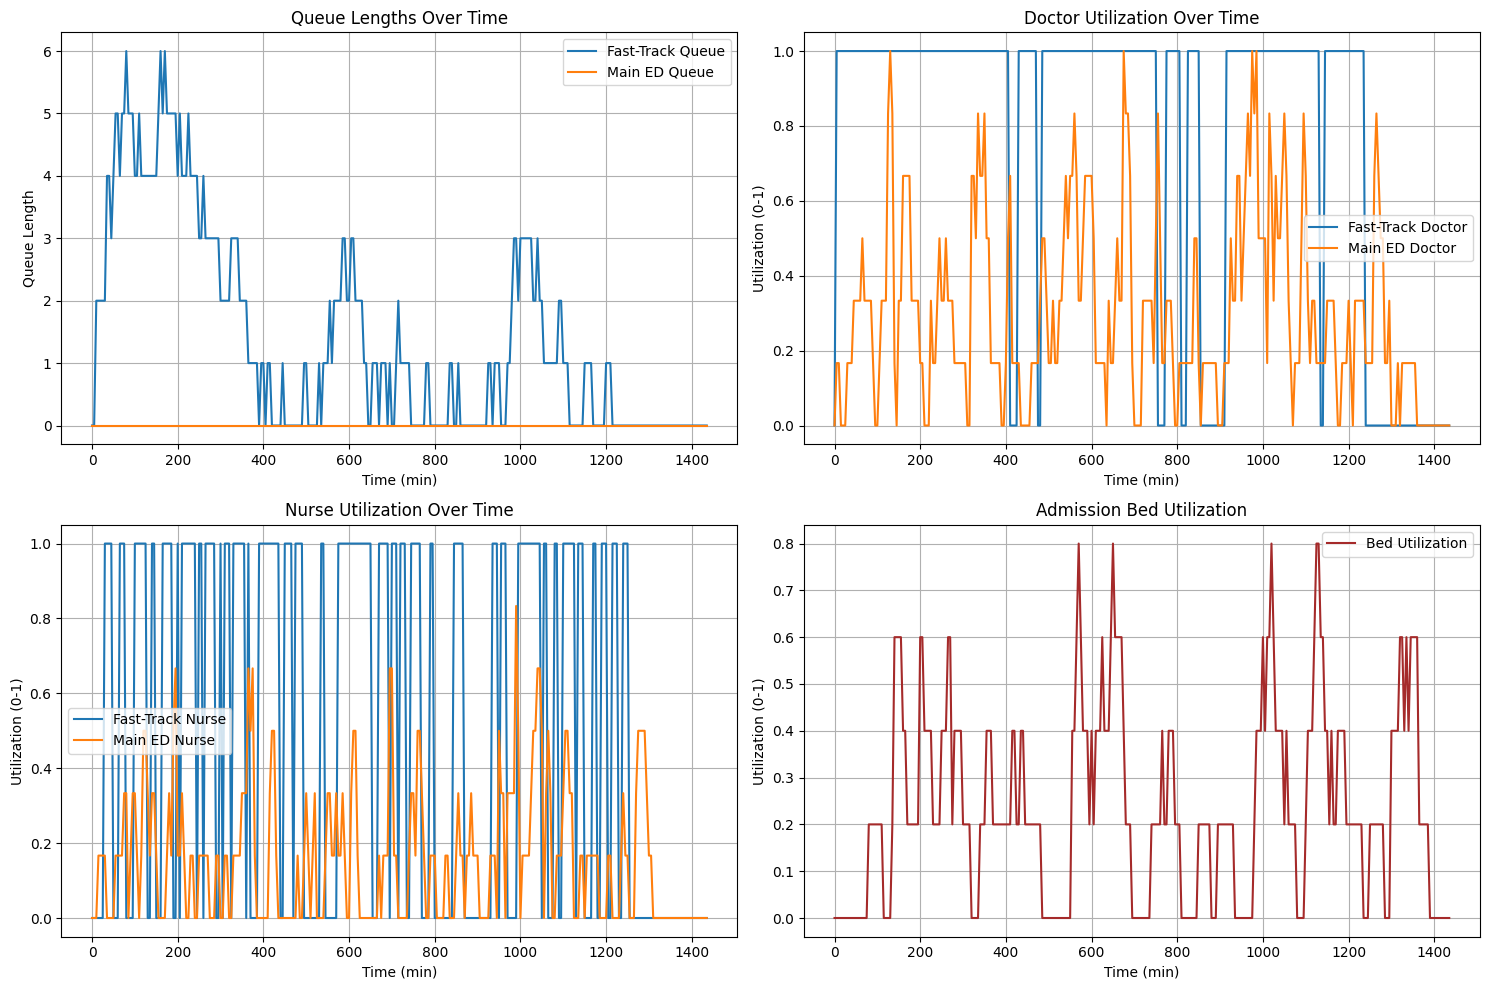

In [7]:
# Set input variables
ARRIVAL_RATE = 10 # mean inter-arrival time
N_PATIENTS = 144
SIM_TIME = 1440 # mins - 24 hours

# Set configurations
config = {
            "fast_doctors": 1,
            "fast_nurses": 1,
            "ed_doctors": 6,
            "ed_nurses": 6,
            "beds": 5,
        }

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# --- Run Simulation ---
def run_simulation(config, n_patients, sim_time, arrival_rate):
    global wait_times, timeline
    global queue_fast, queue_ed
    global util_fast_doc, util_fast_nurse, util_ed_doc, util_ed_nurse, util_beds

    # Reset globals
    wait_times, timeline = [], []
    queue_fast, queue_ed = [], []
    util_fast_doc, util_fast_nurse = [], []
    util_ed_doc, util_ed_nurse = [], []
    util_beds = []

    env = simpy.Environment()
    hospital = Hospital(
    env,
    config["fast_doctors"],
    config["fast_nurses"],
    config["ed_doctors"],
    config["ed_nurses"],
    config["beds"]
)

    # Schedule patient arrivals
    def source(env, Hospital, n_patients):
        for i in range(n_patients):
            env.process(patient(env, f"Patient {i+1}", hospital))
            yield env.timeout(np.random.exponential(arrival_rate))

    env.process(source(env, hospital, N_PATIENTS))
    env.process(monitor(env, hospital, timeline,
                        queue_fast, queue_ed,
                        util_fast_doc, util_fast_nurse,
                        util_ed_doc, util_ed_nurse,
                        util_beds))
    env.run(until=SIM_TIME)

    # --- Report ---
    report(wait_times, timeline,
        queue_fast, queue_ed,
        util_fast_doc, util_fast_nurse,
        util_ed_doc, util_ed_nurse,
        util_beds)
    
    # revert 

# Run simulation. 
run_simulation(config, N_PATIENTS, SIM_TIME, ARRIVAL_RATE)

#### Run simple optimisation algorithm for objective: patient wait time
- Run 10 simulations with 10 random configurations of resources (Random Search)
- **Purpose:** Design optimal resource configurations/system capacity? I.e. How do we optimise no. of doctors, nurses & beds?

In [8]:
import pandas as pd
def optimize_ed_resources(n_iter=10):
    results = []

    for i in range(n_iter):
        config = {
            "fast_doctors": random.randint(1, 3),
            "fast_nurses": random.randint(1, 3),
            "ed_doctors": random.randint(3, 8),
            "ed_nurses": random.randint(3, 8),
            "beds": random.randint(3, 10),
        }

        run_simulation(config, N_PATIENTS, SIM_TIME, ARRIVAL_RATE) # how to reset input variables after each simulation? Fix*
        avg_wait = np.mean(wait_times)
        results.append({**config, "avg_wait_time": avg_wait})

    df = pd.DataFrame(results).sort_values(by="avg_wait_time")
    return df

=== Hospital ED Simulation Metrics ===
Average Wait Time (min): 73.17
Max Wait Time (min): 140.15

--- Queue Lengths ---
Avg Fast-Track Queue Length: 0.05
Avg Main ED Queue Length:    0.00

--- Resource Utilizations ---
Fast-Track Doctor Util (%):  37.85
Fast-Track Nurse Util (%):   18.06
Main ED Doctor Util (%):     30.79
Main ED Nurse Util (%):      12.20
Bed Utilization (%):         20.00


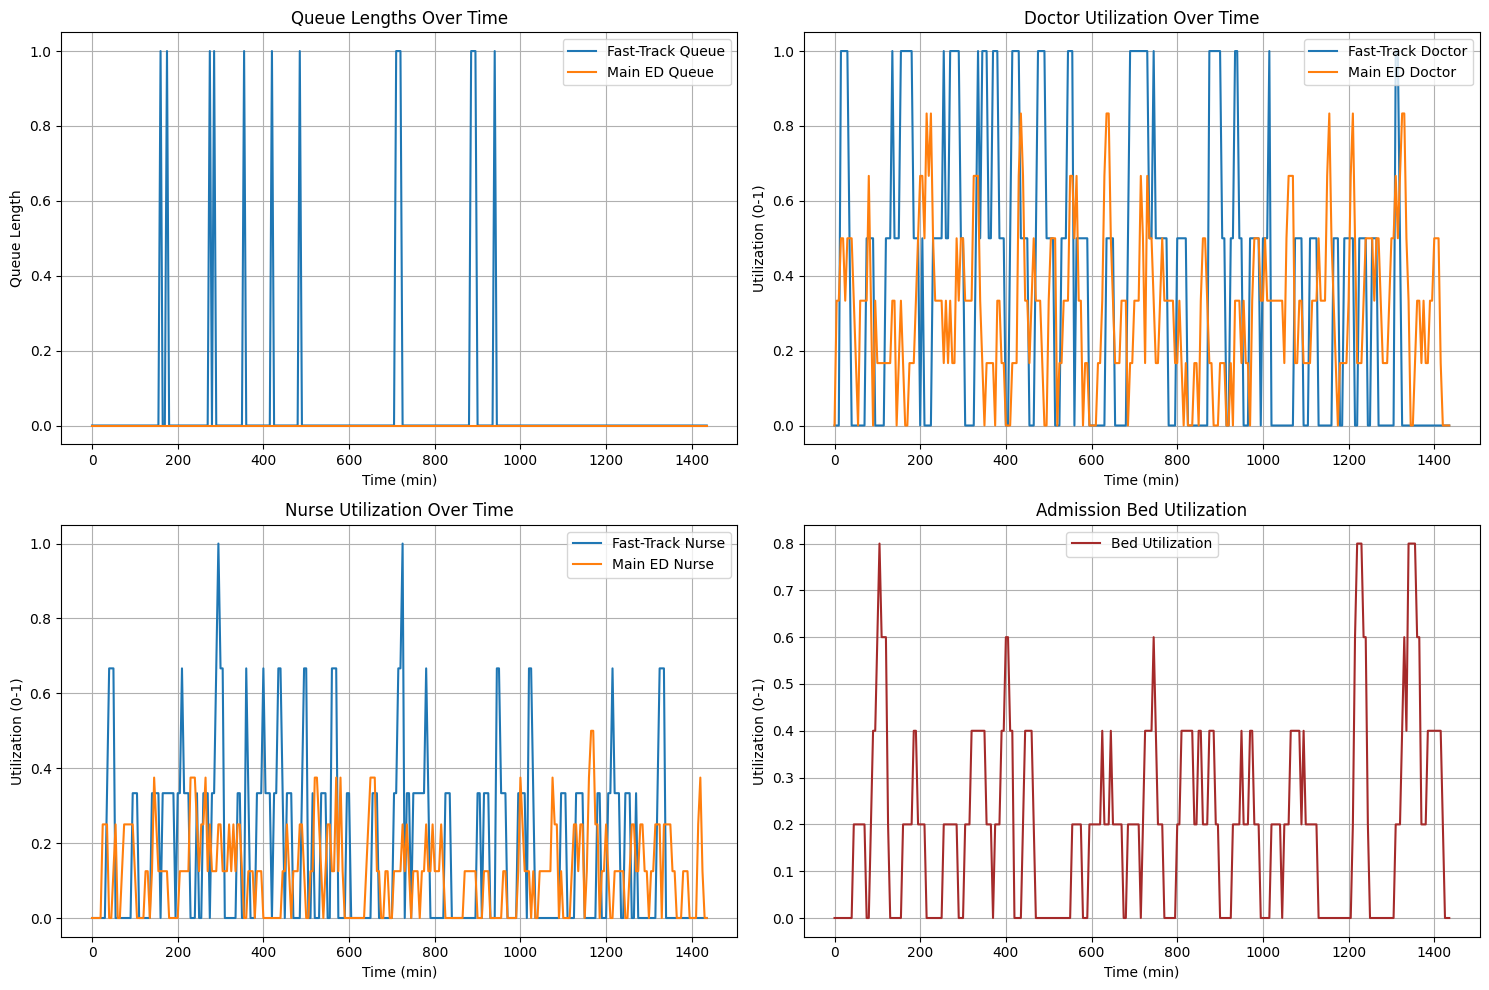

=== Hospital ED Simulation Metrics ===
Average Wait Time (min): 80.36
Max Wait Time (min): 151.74

--- Queue Lengths ---
Avg Fast-Track Queue Length: 0.00
Avg Main ED Queue Length:    0.63

--- Resource Utilizations ---
Fast-Track Doctor Util (%):  18.75
Fast-Track Nurse Util (%):   20.49
Main ED Doctor Util (%):     67.59
Main ED Nurse Util (%):      25.78
Bed Utilization (%):         30.03


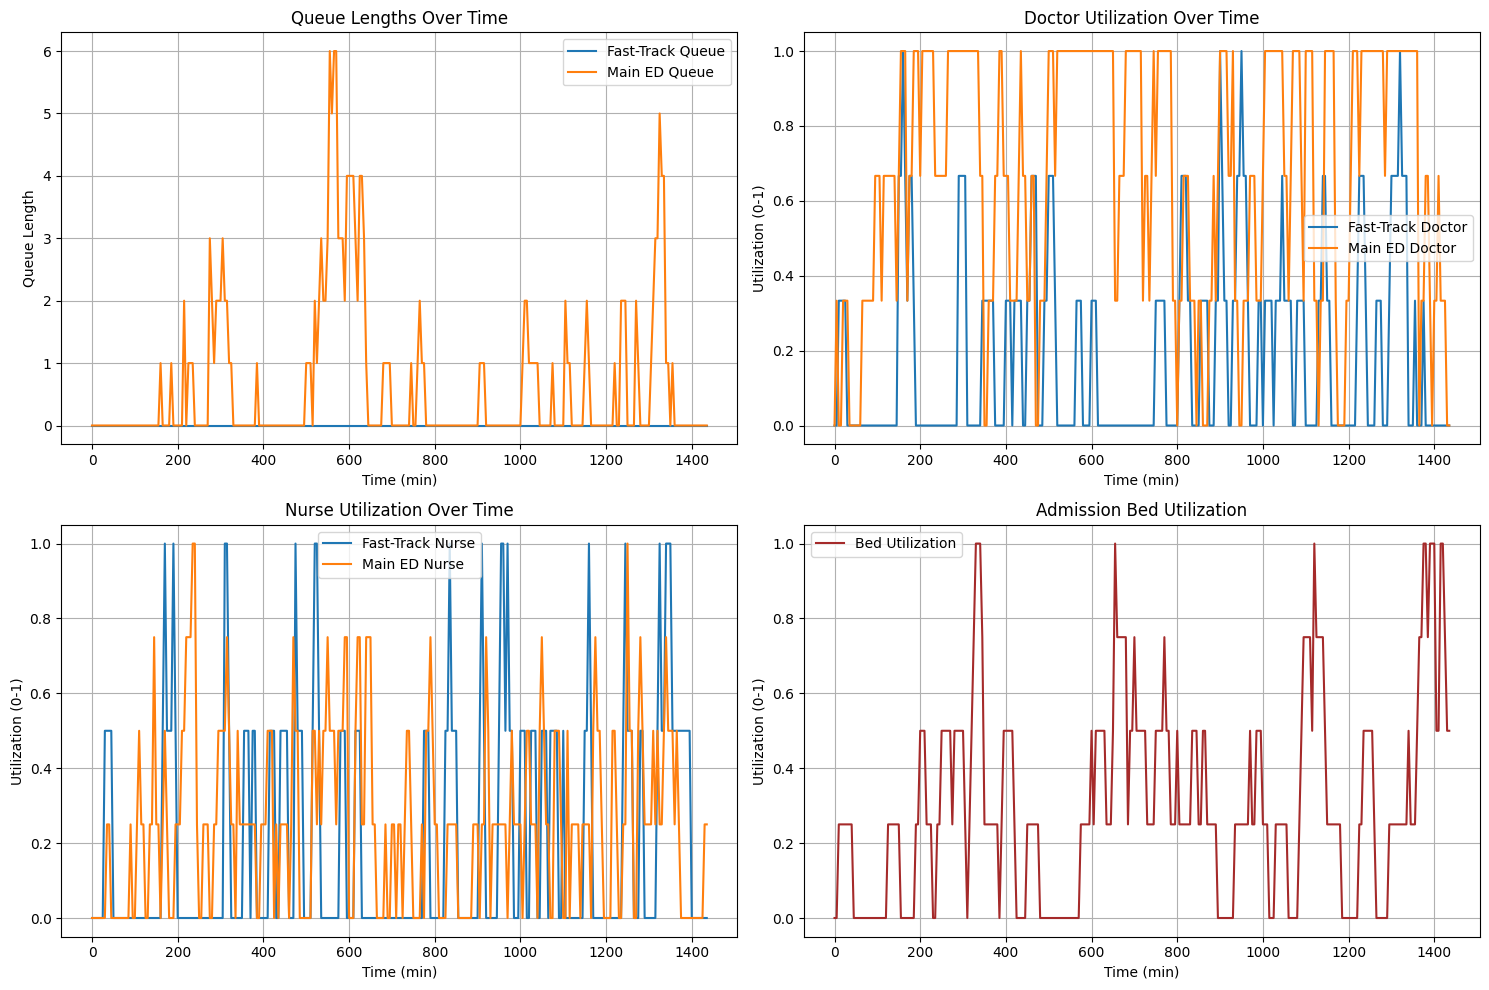

=== Hospital ED Simulation Metrics ===
Average Wait Time (min): 73.38
Max Wait Time (min): 140.18

--- Queue Lengths ---
Avg Fast-Track Queue Length: 0.57
Avg Main ED Queue Length:    0.00

--- Resource Utilizations ---
Fast-Track Doctor Util (%):  69.44
Fast-Track Nurse Util (%):   49.65
Main ED Doctor Util (%):     26.85
Main ED Nurse Util (%):      12.70
Bed Utilization (%):         12.27


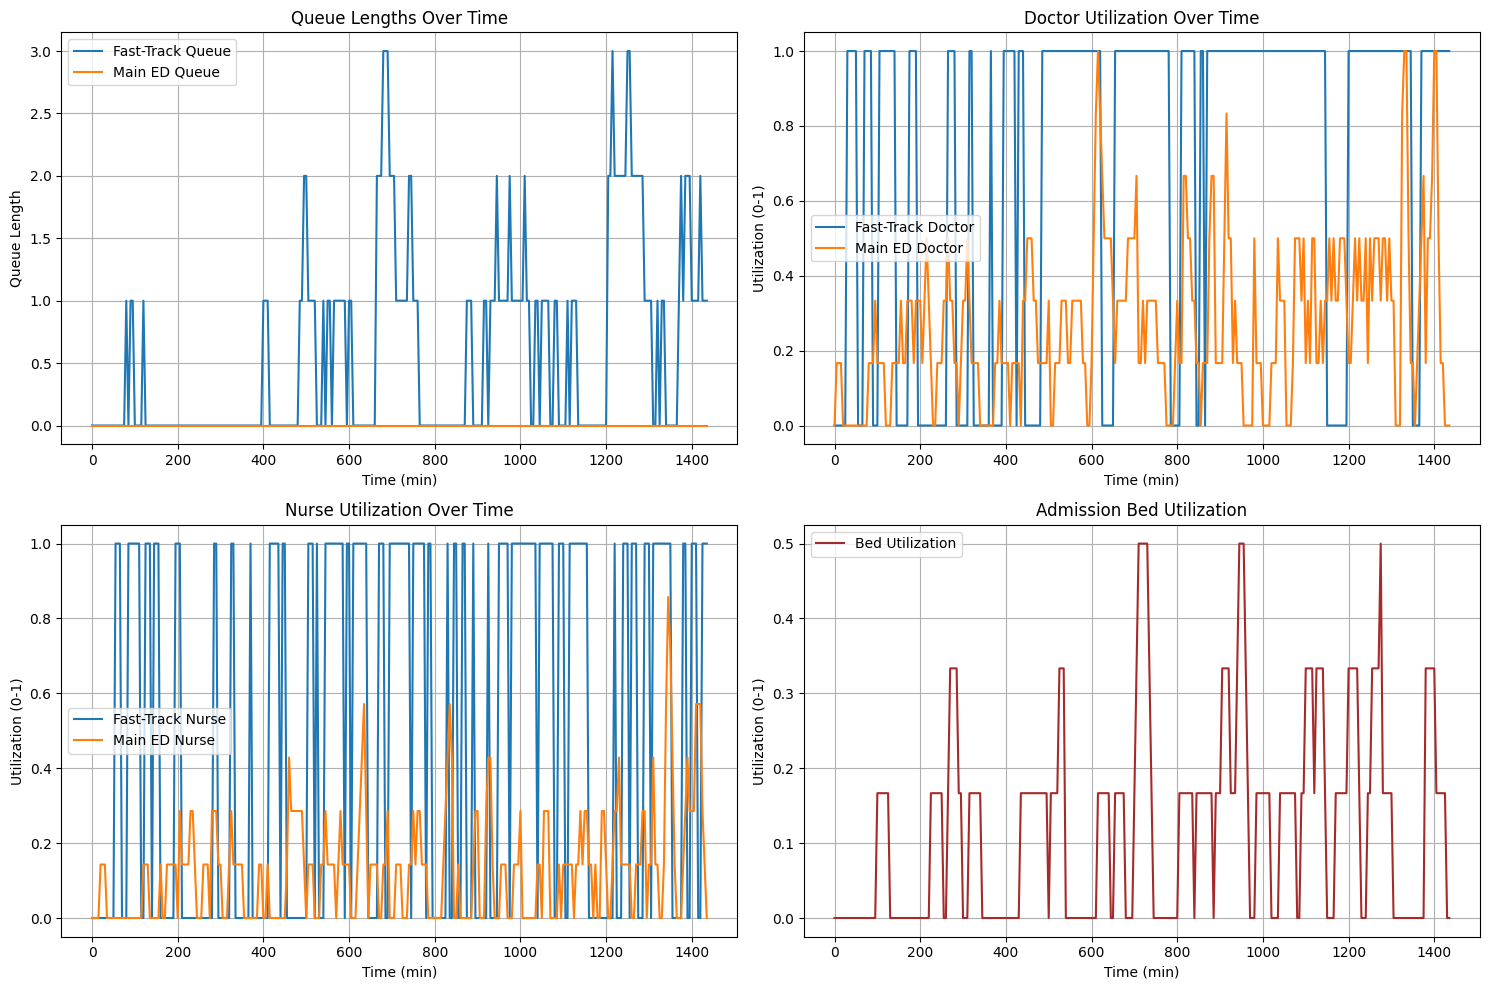

=== Hospital ED Simulation Metrics ===
Average Wait Time (min): 74.51
Max Wait Time (min): 134.14

--- Queue Lengths ---
Avg Fast-Track Queue Length: 0.09
Avg Main ED Queue Length:    0.04

--- Resource Utilizations ---
Fast-Track Doctor Util (%):  32.81
Fast-Track Nurse Util (%):   15.62
Main ED Doctor Util (%):     32.52
Main ED Nurse Util (%):      26.30
Bed Utilization (%):         26.04


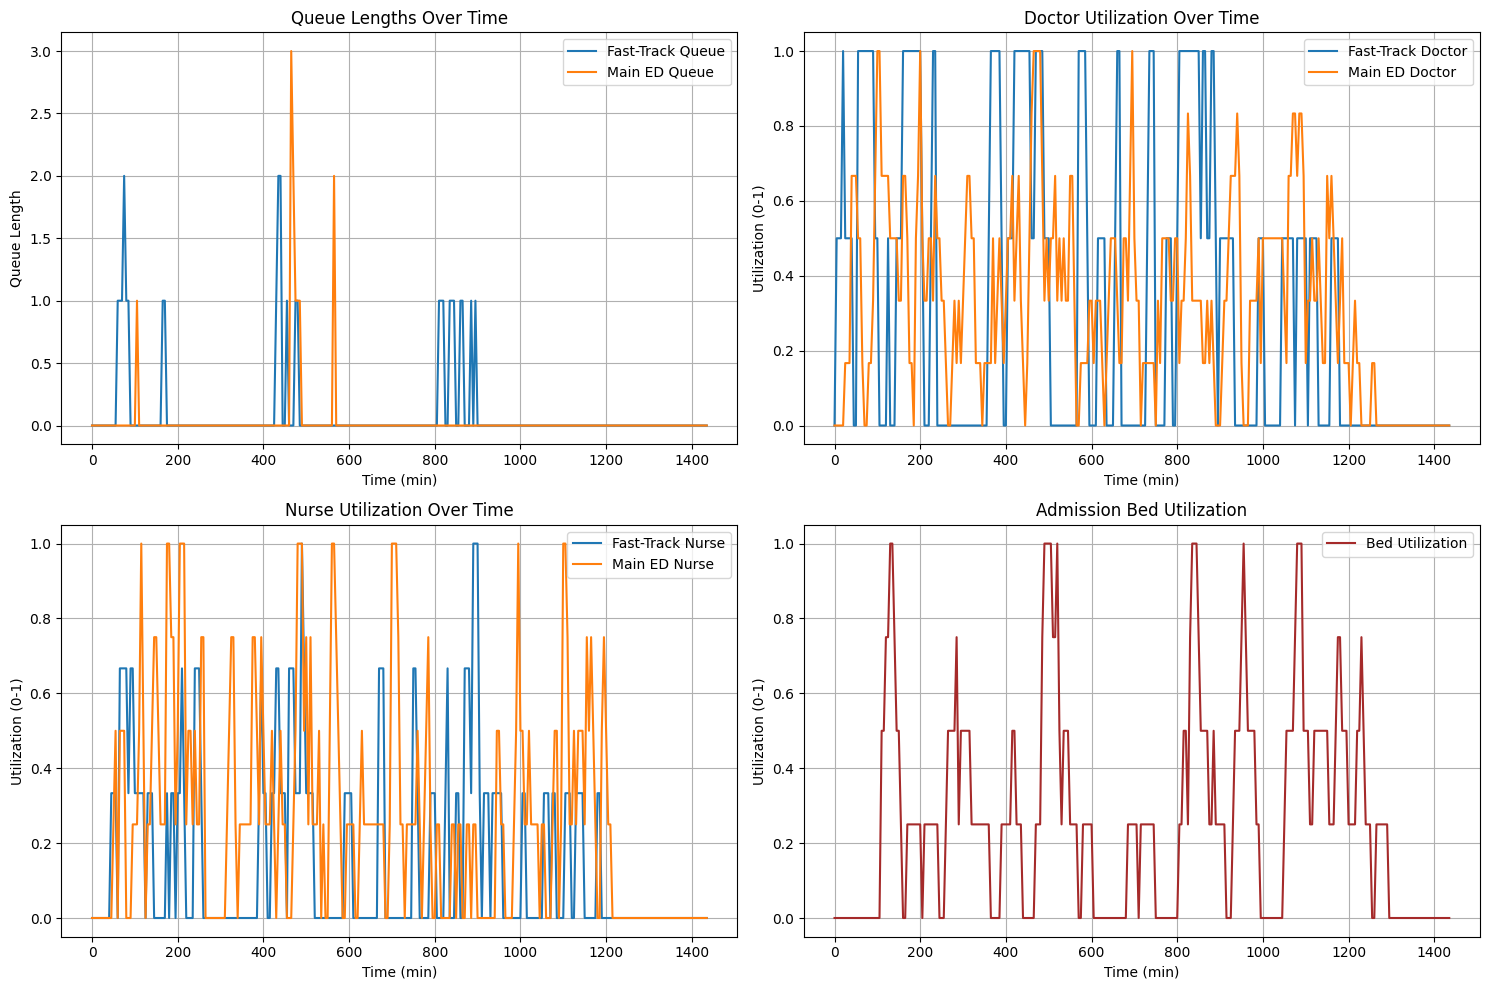

=== Hospital ED Simulation Metrics ===
Average Wait Time (min): 77.94
Max Wait Time (min): 141.58

--- Queue Lengths ---
Avg Fast-Track Queue Length: 0.14
Avg Main ED Queue Length:    0.00

--- Resource Utilizations ---
Fast-Track Doctor Util (%):  19.79
Fast-Track Nurse Util (%):   43.06
Main ED Doctor Util (%):     29.07
Main ED Nurse Util (%):      21.30
Bed Utilization (%):         11.41


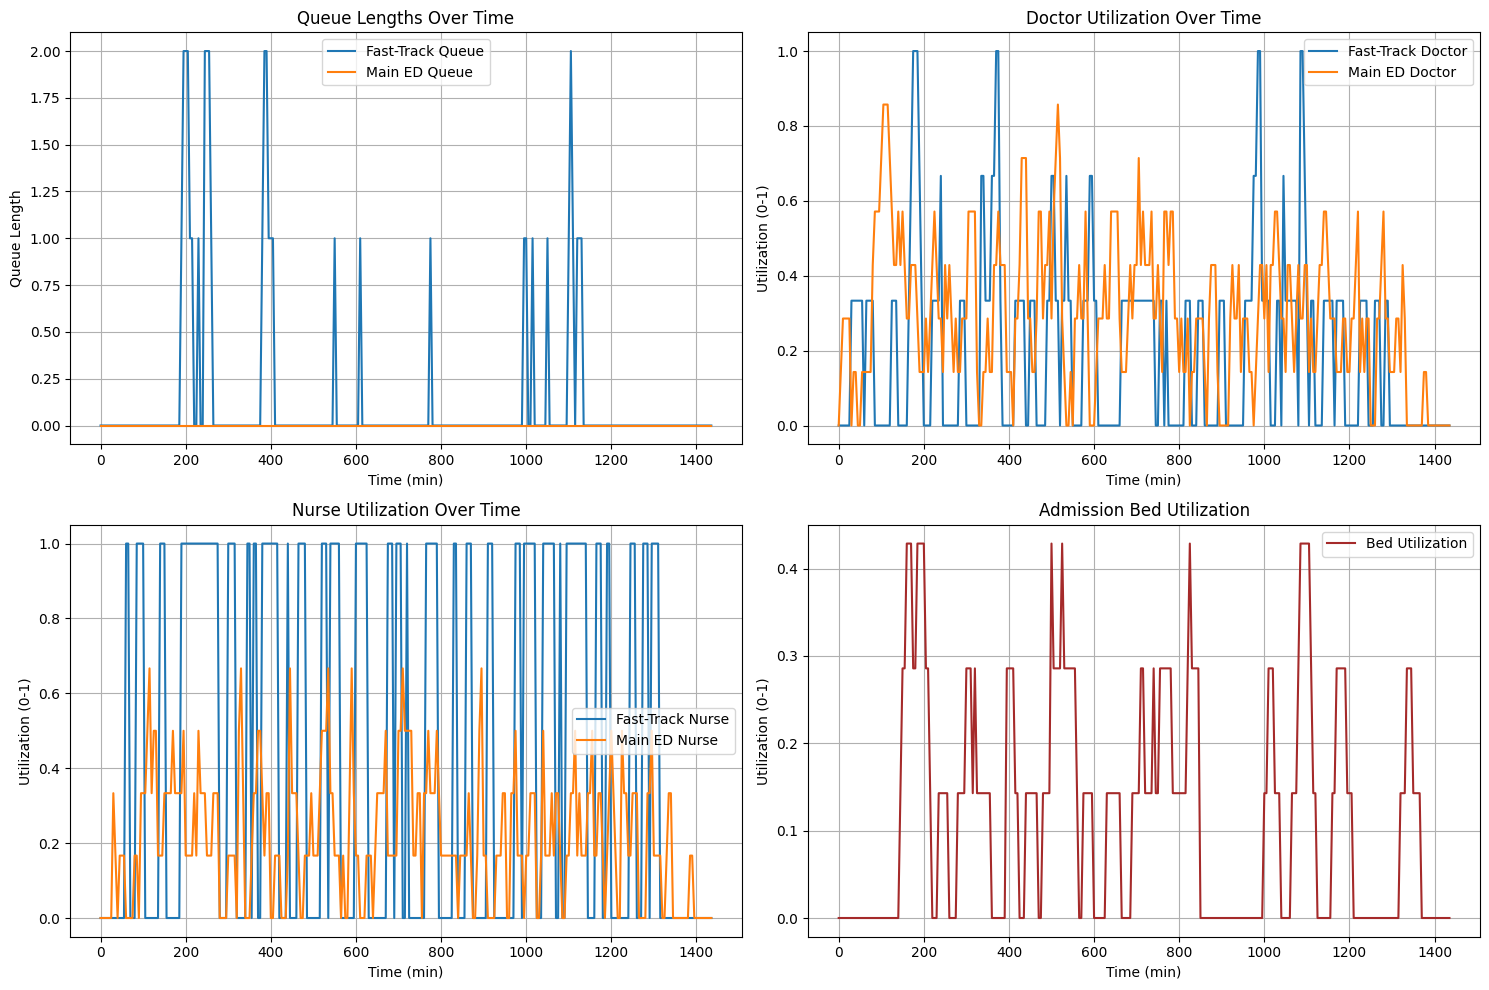

=== Hospital ED Simulation Metrics ===
Average Wait Time (min): 70.69
Max Wait Time (min): 140.80

--- Queue Lengths ---
Avg Fast-Track Queue Length: 0.00
Avg Main ED Queue Length:    0.02

--- Resource Utilizations ---
Fast-Track Doctor Util (%):  19.91
Fast-Track Nurse Util (%):   16.78
Main ED Doctor Util (%):     36.81
Main ED Nurse Util (%):      23.70
Bed Utilization (%):         37.04


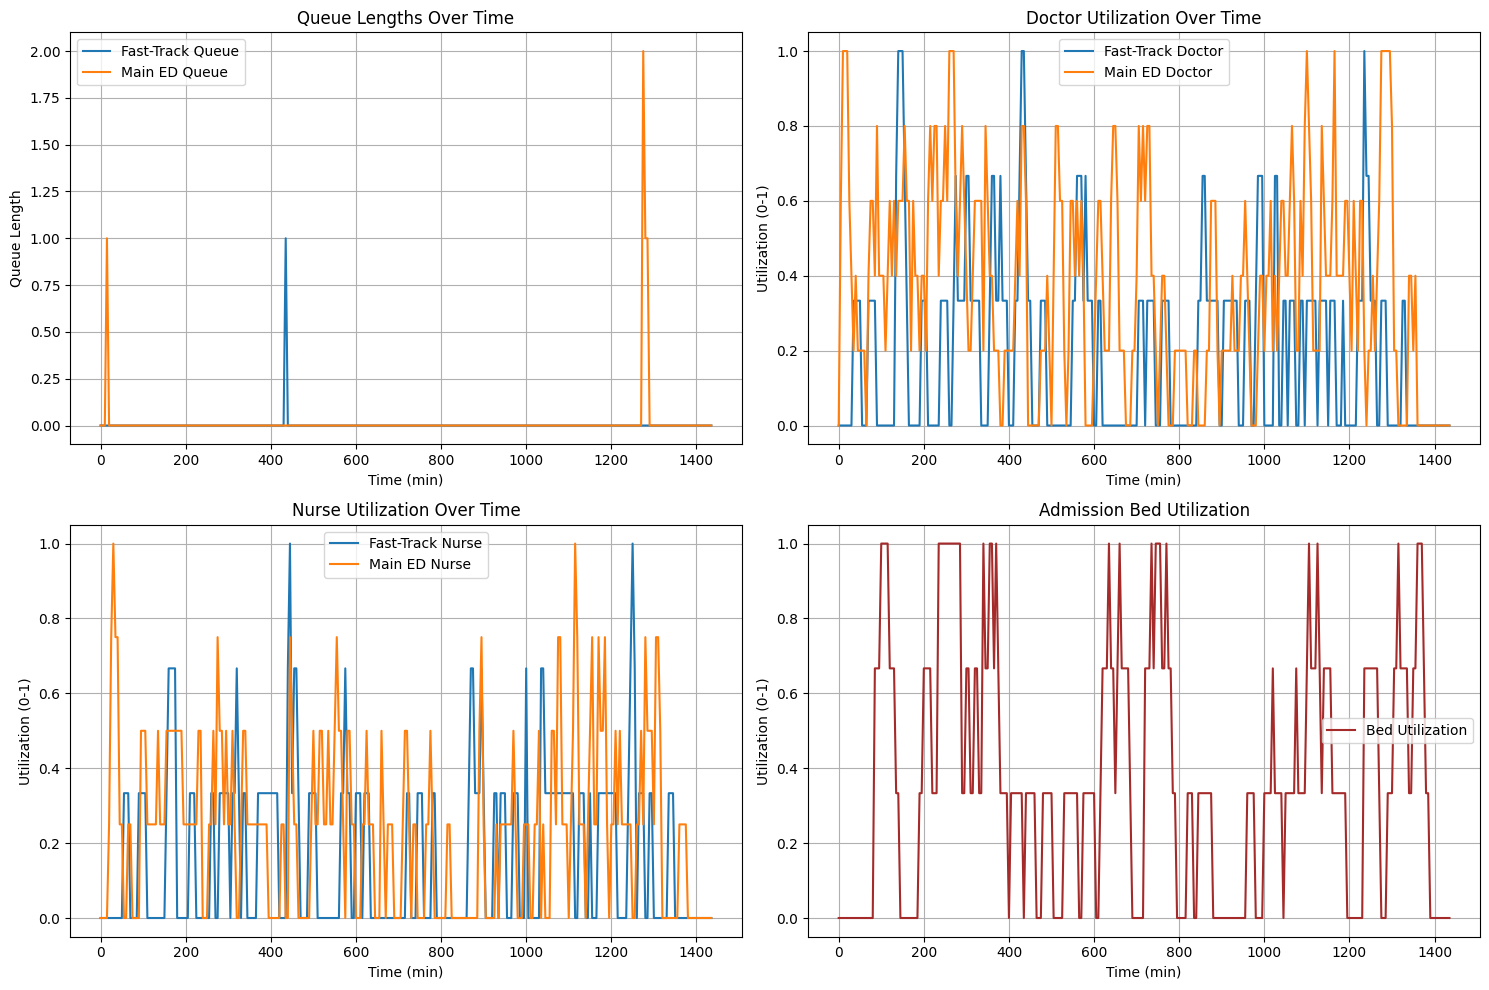

=== Hospital ED Simulation Metrics ===
Average Wait Time (min): 77.70
Max Wait Time (min): 161.06

--- Queue Lengths ---
Avg Fast-Track Queue Length: 0.74
Avg Main ED Queue Length:    0.00

--- Resource Utilizations ---
Fast-Track Doctor Util (%):  74.65
Fast-Track Nurse Util (%):   15.62
Main ED Doctor Util (%):     22.83
Main ED Nurse Util (%):      11.07
Bed Utilization (%):         12.46


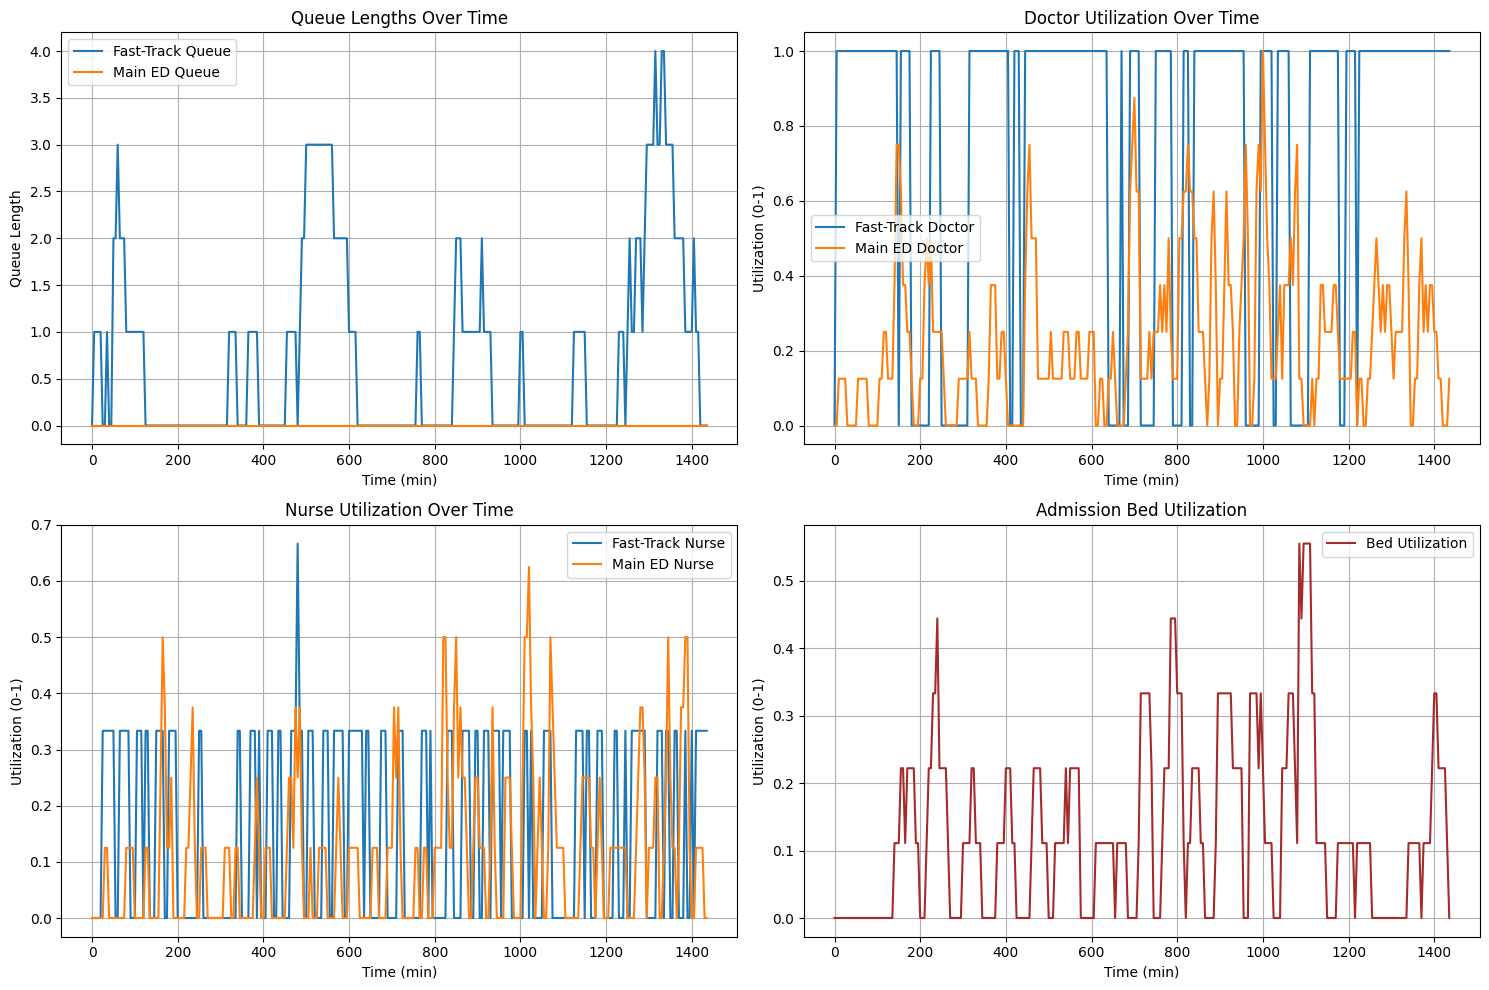

=== Hospital ED Simulation Metrics ===
Average Wait Time (min): 74.70
Max Wait Time (min): 156.09

--- Queue Lengths ---
Avg Fast-Track Queue Length: 0.28
Avg Main ED Queue Length:    0.00

--- Resource Utilizations ---
Fast-Track Doctor Util (%):  22.69
Fast-Track Nurse Util (%):   46.88
Main ED Doctor Util (%):     26.54
Main ED Nurse Util (%):      17.43
Bed Utilization (%):         14.80


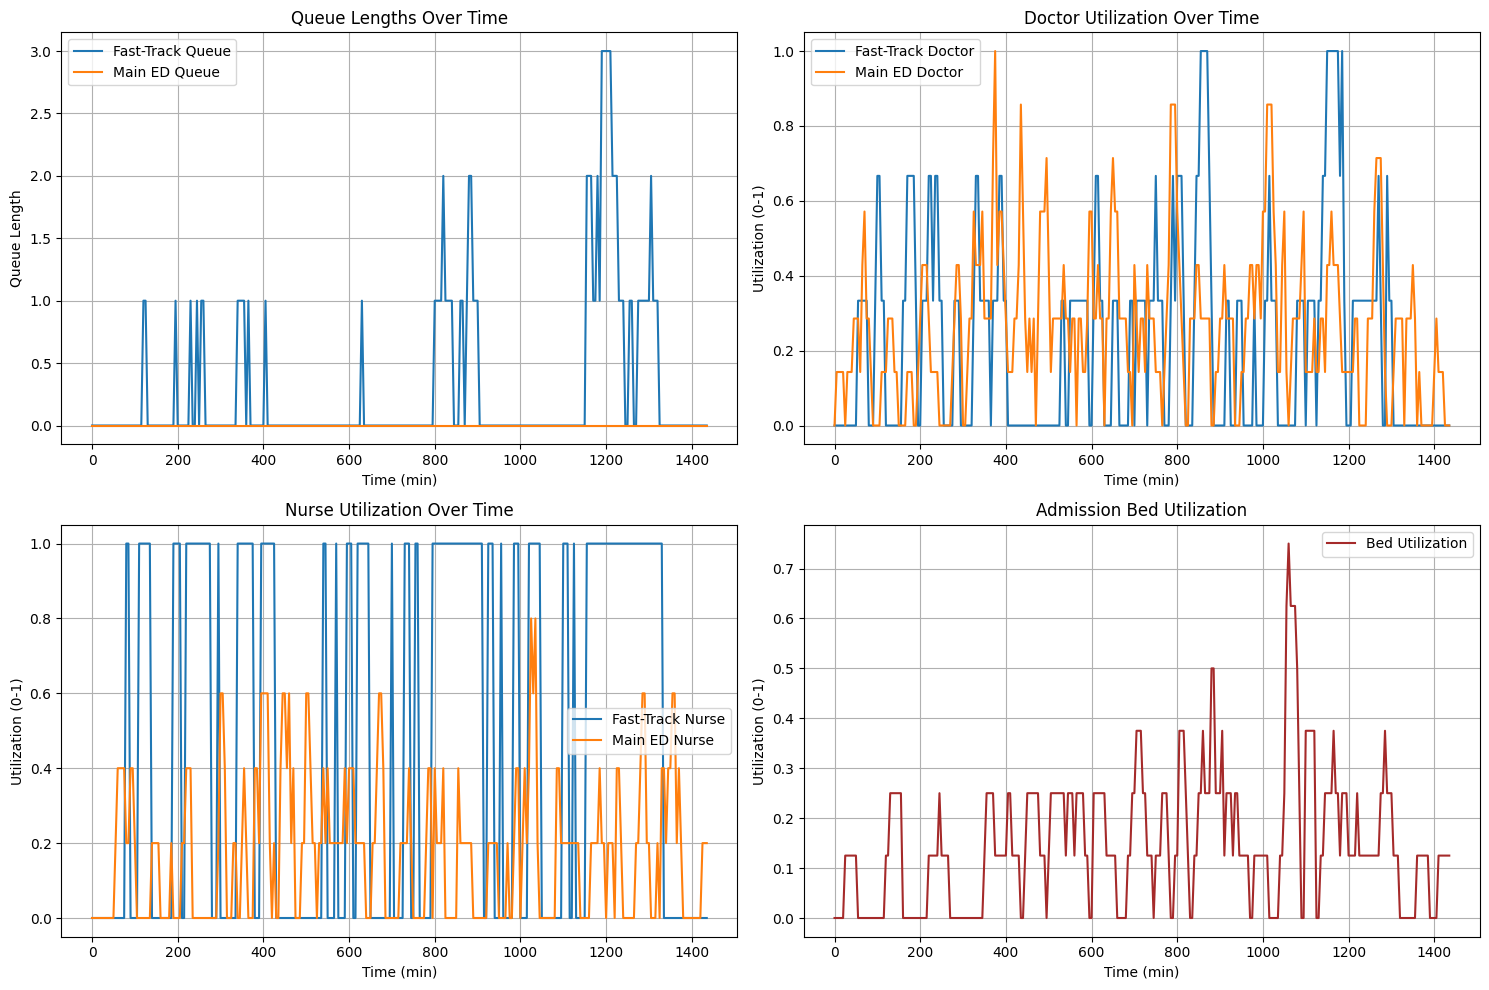

=== Hospital ED Simulation Metrics ===
Average Wait Time (min): 70.07
Max Wait Time (min): 144.07

--- Queue Lengths ---
Avg Fast-Track Queue Length: 0.00
Avg Main ED Queue Length:    0.18

--- Resource Utilizations ---
Fast-Track Doctor Util (%):  21.88
Fast-Track Nurse Util (%):   16.67
Main ED Doctor Util (%):     60.42
Main ED Nurse Util (%):      32.52
Bed Utilization (%):         16.94


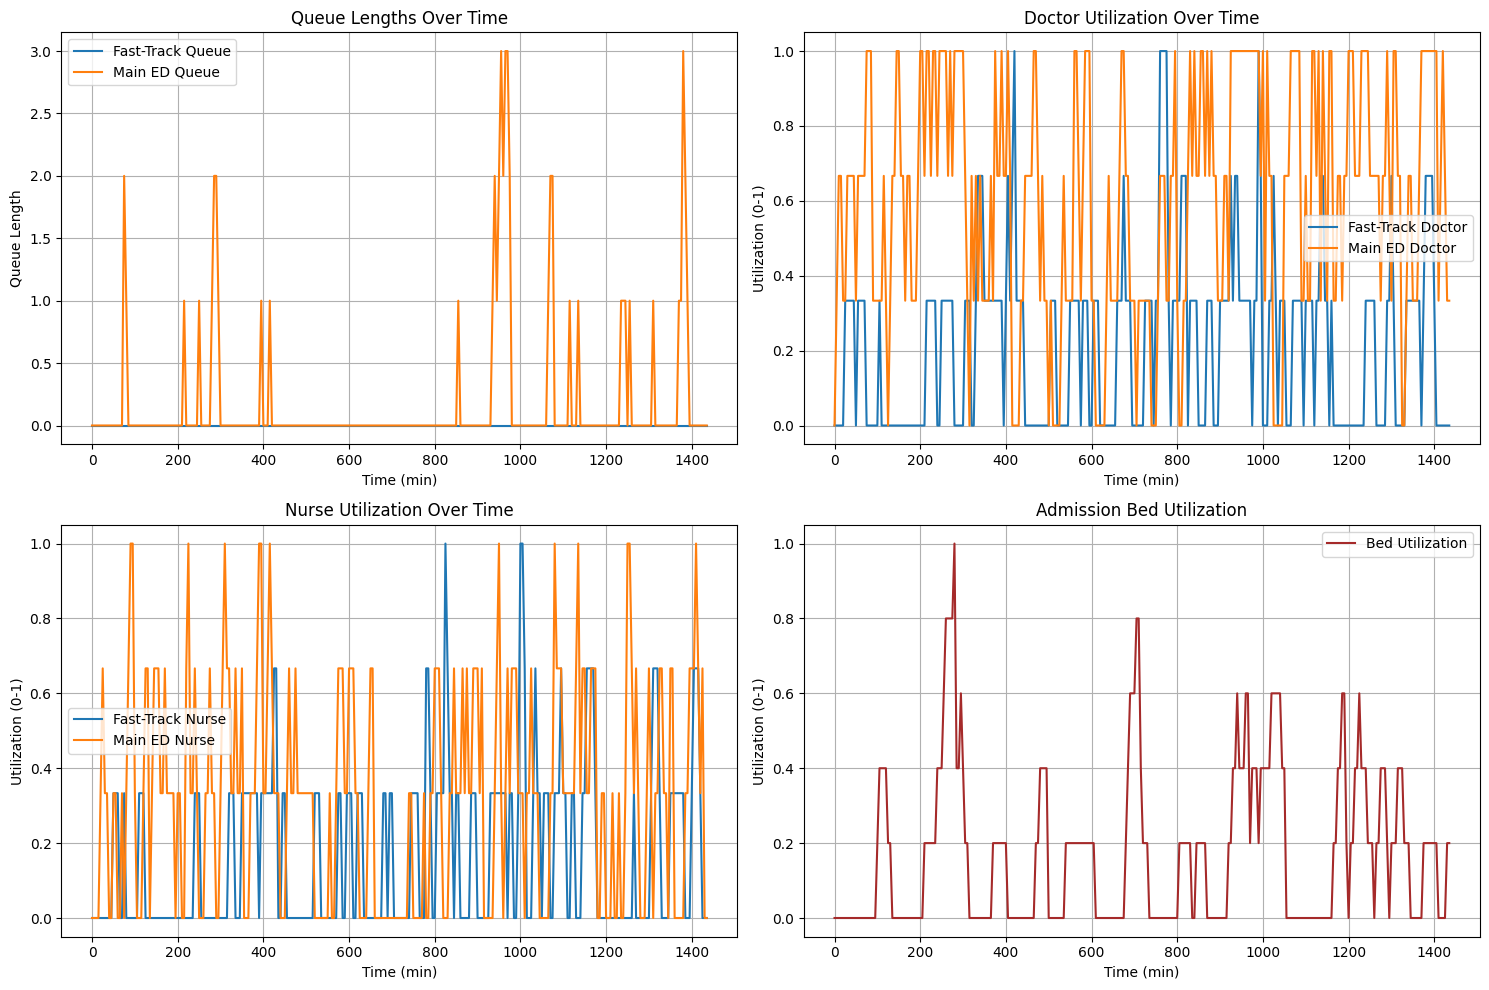

=== Hospital ED Simulation Metrics ===
Average Wait Time (min): 77.30
Max Wait Time (min): 133.54

--- Queue Lengths ---
Avg Fast-Track Queue Length: 0.18
Avg Main ED Queue Length:    0.05

--- Resource Utilizations ---
Fast-Track Doctor Util (%):  21.99
Fast-Track Nurse Util (%):   47.92
Main ED Doctor Util (%):     38.54
Main ED Nurse Util (%):      16.72
Bed Utilization (%):         18.69


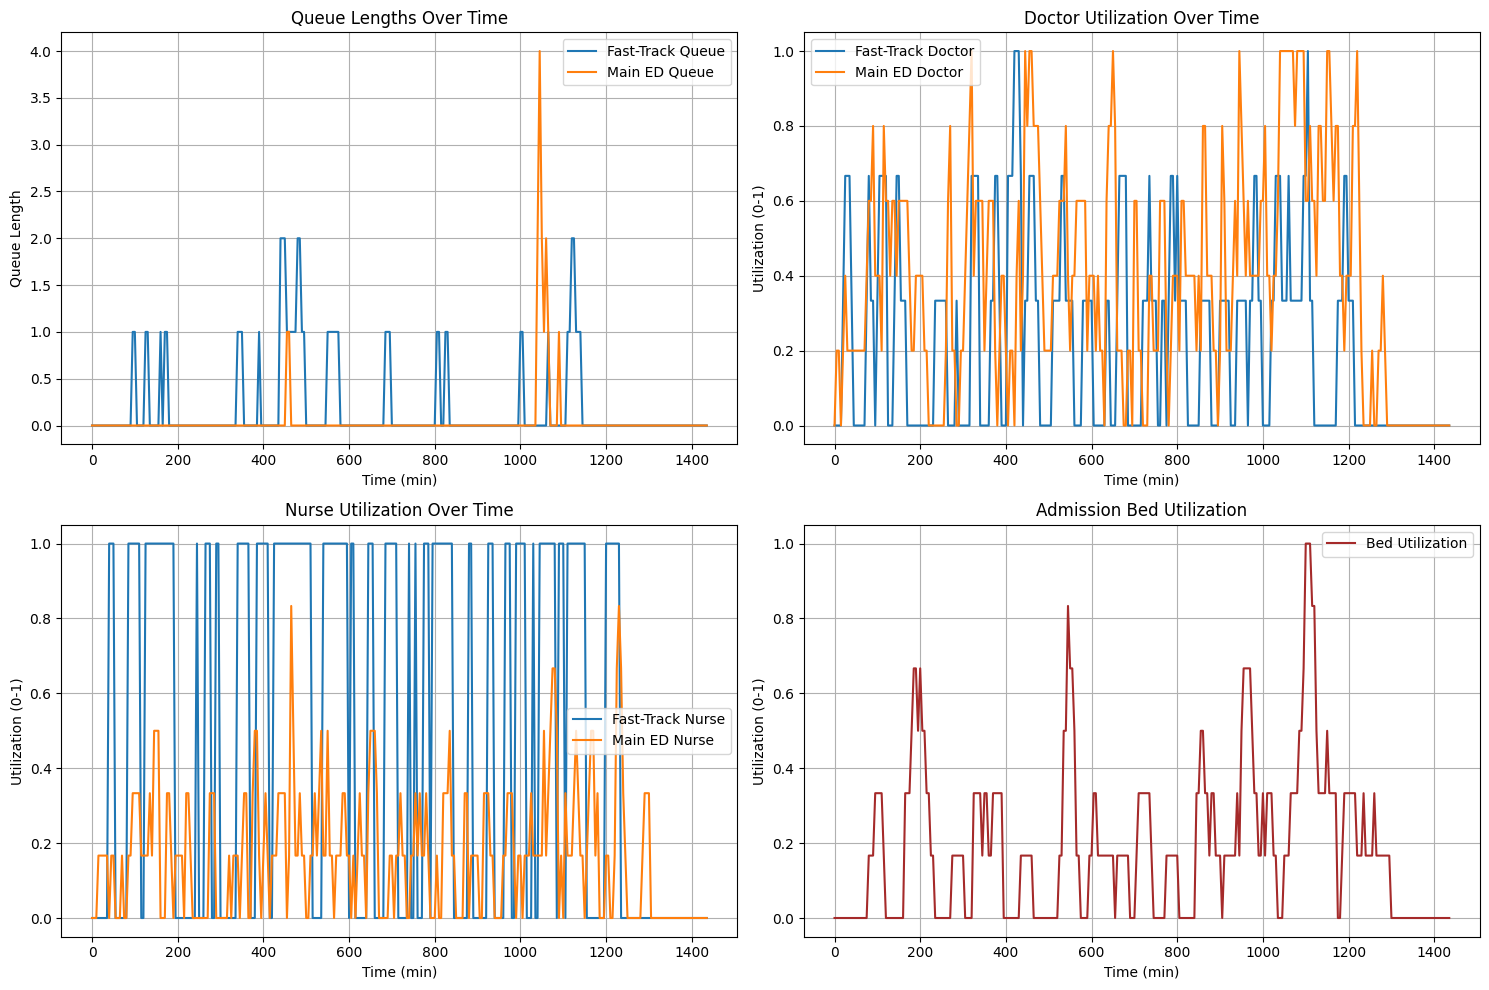

fast_doctors  fast_nurses  ed_doctors  ed_nurses  beds  avg_wait_time
8             3            3           3          3     5      70.072753
5             3            3           5          4     3      70.686475
0             2            3           6          8     5      73.168884
2             1            1           6          7     6      73.382525
3             2            3           6          4     4      74.509703
7             3            1           7          5     8      74.700947
9             3            1           5          6     6      77.301384
6             1            3           8          8     9      77.702029
4             3            1           7          6     7      77.944399
1             3            2           3          4     4      80.364836

In [9]:
# print results
df_results = optimize_ed_resources(n_iter=10)
df_results

In [10]:
print(config)

{'fast_doctors': 1, 'fast_nurses': 1, 'ed_doctors': 6, 'ed_nurses': 6, 'beds': 5}
